In [1]:
# Import reqired libraries
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import gaussian_kde
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set display options
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set display width to a high value

In [2]:
# Function to print colored text
def print_colored(text, color):
    color_codes = {
        'black': '0;30',
        'red': '0;31',
        'green': '0;32',
        'yellow': '0;33',
        'blue': '0;34',
        'purple': '0;35',
        'cyan': '0;36',
        'white': '0;37',
        'bold_black': '1;30',
        'bold_red': '1;31',
        'bold_green': '1;32',
        'bold_yellow': '1;33',
        'bold_blue': '1;34',
        'bold_purple': '1;35',
        'bold_cyan': '1;36',
        'bold_white': '1;37'
    }
    color_code = color_codes.get(color, '0;30')  # Default to white if color not found
    print(f"\033[{color_code}m{text}\033[0m")

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        #'text.latex.preamble' : [r'\usepackage{amsmath}'],
        'mathtext.fontset' : 'stix',
        'mathtext.rm' : 'serif'
}
mpl.rcParams.update(nice_fonts)

In [3]:
# Load the dataset
data = pd.read_csv('Sweden_data_processed.csv')

In [4]:
# 1. Descriptive Statistics

# Calculating basic descriptive statistics for each indicator
descriptive_stats = data[['GDP', 'Inflation', 'Current_Account_Balance', 'Unemployment']].describe(percentiles=[.25, .5, .75])

# Additional statistics: Median (50th percentile is already in describe), and Quartiles
mean_values = data[['GDP', 'Inflation', 'Current_Account_Balance', 'Unemployment']].mean()
median_values = data[['GDP', 'Inflation', 'Current_Account_Balance', 'Unemployment']].median()
std_dev = data[['GDP', 'Inflation', 'Current_Account_Balance', 'Unemployment']].std()

# Interpreting the results
descriptive_stats.loc['mean'] = mean_values
descriptive_stats.loc['median'] = median_values
descriptive_stats.loc['std'] = std_dev

In [5]:
descriptive_stats.iloc[1:,:]

,GDP,Inflation,Current_Account_Balance,Unemployment
mean,2.603648e+11,4.394541,2.254886,5.700041
std,2.005899e+11,3.669342,3.112236,2.397883
min,1.595320e+10,-0.494461,-3.104762,1.460000
25%,8.774290e+10,1.678167,-0.286397,3.420750
50%,2.357147e+11,3.174407,2.254886,5.700041
75%,4.502159e+11,7.250483,5.259040,7.516250
max,6.397150e+11,13.706322,8.146859,10.359000
median,2.357147e+11,3.174407,2.254886,5.700041


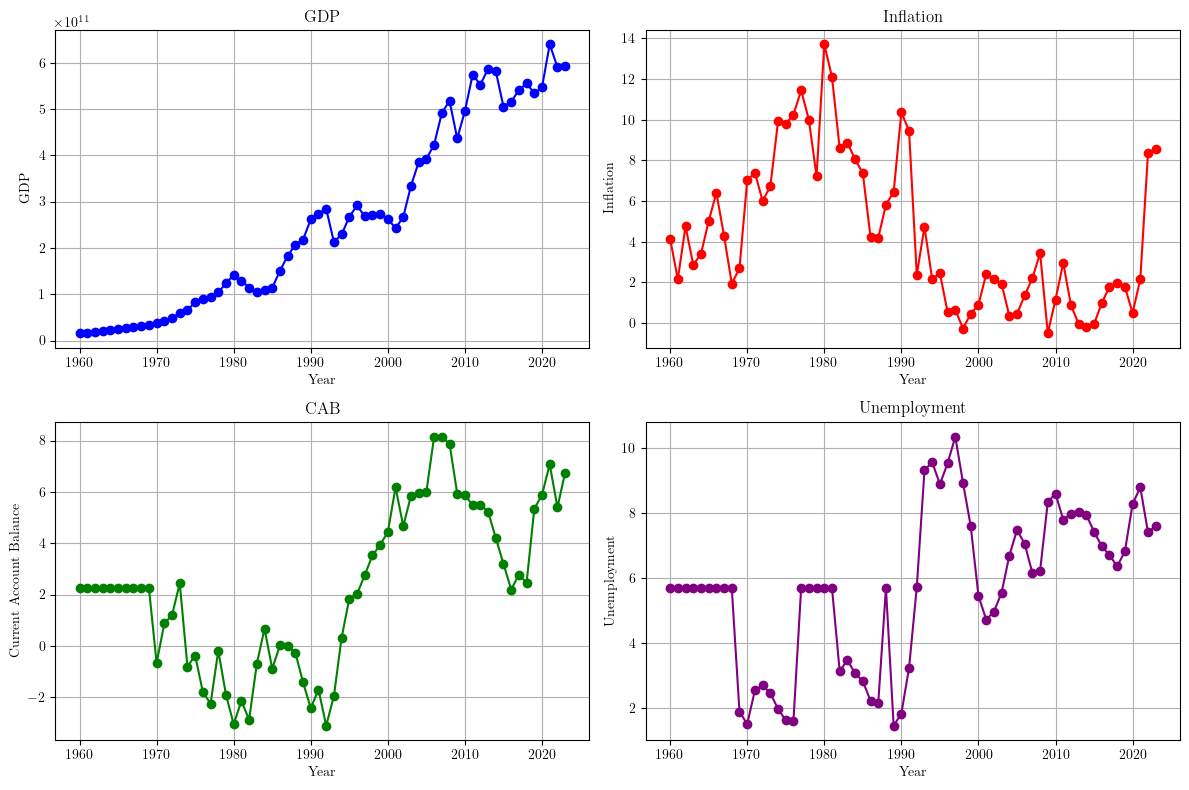

In [6]:
# 2. Trend Analysis

# Create Time Series Plots for each economic indicator
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# GDP over time
axes[0, 0].plot(data['Year'], data['GDP'], marker='o', linestyle='-', color='b')
axes[0, 0].set_title('GDP')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('GDP')
axes[0, 0].grid()

# Inflation over time
axes[0, 1].plot(data['Year'], data['Inflation'], marker='o', linestyle='-', color='r')
axes[0, 1].set_title('Inflation')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Inflation')
axes[0, 1].grid()

# Current Account Balance over time
axes[1, 0].plot(data['Year'], data['Current_Account_Balance'], marker='o', linestyle='-', color='g')
axes[1, 0].set_title('CAB')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Current Account Balance')
axes[1, 0].grid()

# Unemployment over time
axes[1, 1].plot(data['Year'], data['Unemployment'], marker='o', linestyle='-', color='purple')
axes[1, 1].set_title('Unemployment')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Unemployment')
axes[1, 1].grid()

plt.tight_layout()
plt.savefig('observations_vs_time.pdf')
plt.show()



## Result:

**First few years data for current account balance and Unemployment are not available**.

- GDP: There's a clear upward trend, which indicates consistent economic growth. However, notable slowdowns or dips around the early 1990s and the 2008 financial crisis are visible, reflecting the impacts of global recessions. Notice potential dip related to the Russia-Ukraine war in 2022.
- Inflation: The inflation rate is quite volatile, with spikes in the 1970s and early 1980s, correlating with the oil crises and subsequent economic instability. A notable deflationary period is also seen in the early 1990s, coinciding with Sweden's financial crisis.
- Current Account Balance: The balance fluctuates, showing periods of deficit and surplus. A significant surplus appears in the late 1990s, possibly due to economic reforms and stronger export performance. Trade disruptions due to the Russia-Ukraine conflict in 2022.
- Unemployment: Unemployment shows cyclical patterns, with sharp increases during the early 1990s crisis and after the 2008 financial crisis. The decline in the late 1990s could be linked to economic recovery and labor market reforms.

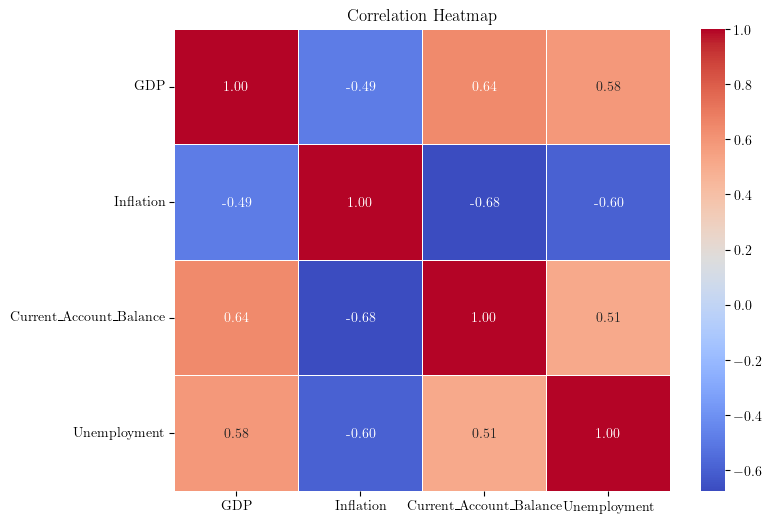

In [7]:
# 3. Correlation Analysis

# Creating a correlation matrix
correlation_matrix = data[['GDP', 'Inflation', 'Current_Account_Balance', 'Unemployment']].corr()

# Visualizing the correlation matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.savefig('corr_matrix.pdf')
plt.show()

In [8]:
correlation_matrix

,GDP,Inflation,Current_Account_Balance,Unemployment
GDP,1.000000,-0.487089,0.640166,0.582702
Inflation,-0.487089,1.000000,-0.675732,-0.596642
Current_Account_Balance,0.640166,-0.675732,1.000000,0.514600
Unemployment,0.582702,-0.596642,0.514600,1.000000


## Result:
The correlation matrix indicates that GDP is negatively correlated with Inflation (-0.49) and positively correlated with both Current Account Balance (0.64) and Unemployment (0.58), suggesting that higher GDP tends to reduce inflation but is unexpectedly linked to higher unemployment, potentially reflecting structural economic issues. Inflation negatively correlates with both Current Account Balance (-0.68) and Unemployment (-0.60), implying that higher inflation weakens the current account and reduces unemployment.

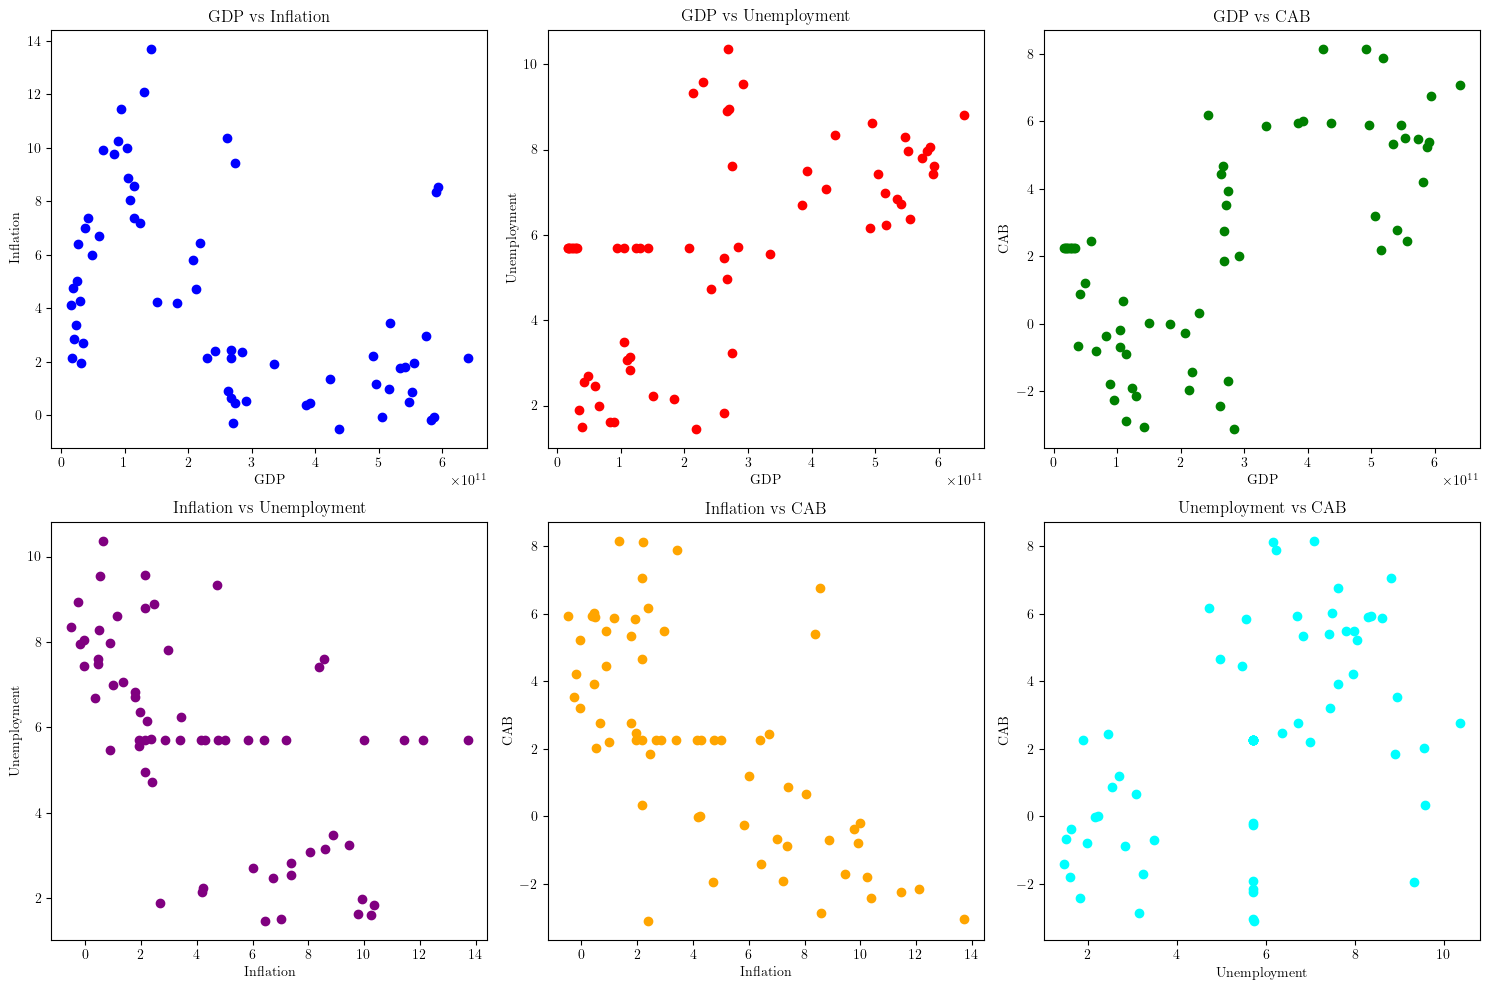

In [9]:
# Creating scatter plots to explore relationships between each pair of indicators
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Scatter plot between GDP and Inflation
axes[0, 0].scatter(data['GDP'], data['Inflation'], color='blue')
axes[0, 0].set_title('GDP vs Inflation')
axes[0, 0].set_xlabel('GDP')
axes[0, 0].set_ylabel('Inflation')

# Scatter plot between GDP and Unemployment
axes[0, 1].scatter(data['GDP'], data['Unemployment'], color='red')
axes[0, 1].set_title('GDP vs Unemployment')
axes[0, 1].set_xlabel('GDP')
axes[0, 1].set_ylabel('Unemployment')

# Scatter plot between GDP and Current Account Balance
axes[0, 2].scatter(data['GDP'], data['Current_Account_Balance'], color='green')
axes[0, 2].set_title('GDP vs CAB')
axes[0, 2].set_xlabel('GDP')
axes[0, 2].set_ylabel('CAB')

# Scatter plot between Inflation and Unemployment
axes[1, 0].scatter(data['Inflation'], data['Unemployment'], color='purple')
axes[1, 0].set_title('Inflation vs Unemployment')
axes[1, 0].set_xlabel('Inflation')
axes[1, 0].set_ylabel('Unemployment')

# Scatter plot between Inflation and Current Account Balance
axes[1, 1].scatter(data['Inflation'], data['Current_Account_Balance'], color='orange')
axes[1, 1].set_title('Inflation vs CAB')
axes[1, 1].set_xlabel('Inflation')
axes[1, 1].set_ylabel('CAB')

# Scatter plot between Unemployment and Current Account Balance
axes[1, 2].scatter(data['Unemployment'], data['Current_Account_Balance'], color='cyan')
axes[1, 2].set_title('Unemployment vs CAB')
axes[1, 2].set_xlabel('Unemployment')
axes[1, 2].set_ylabel('CAB')

plt.tight_layout()
plt.savefig('scatter_analysis.pdf')
plt.show()

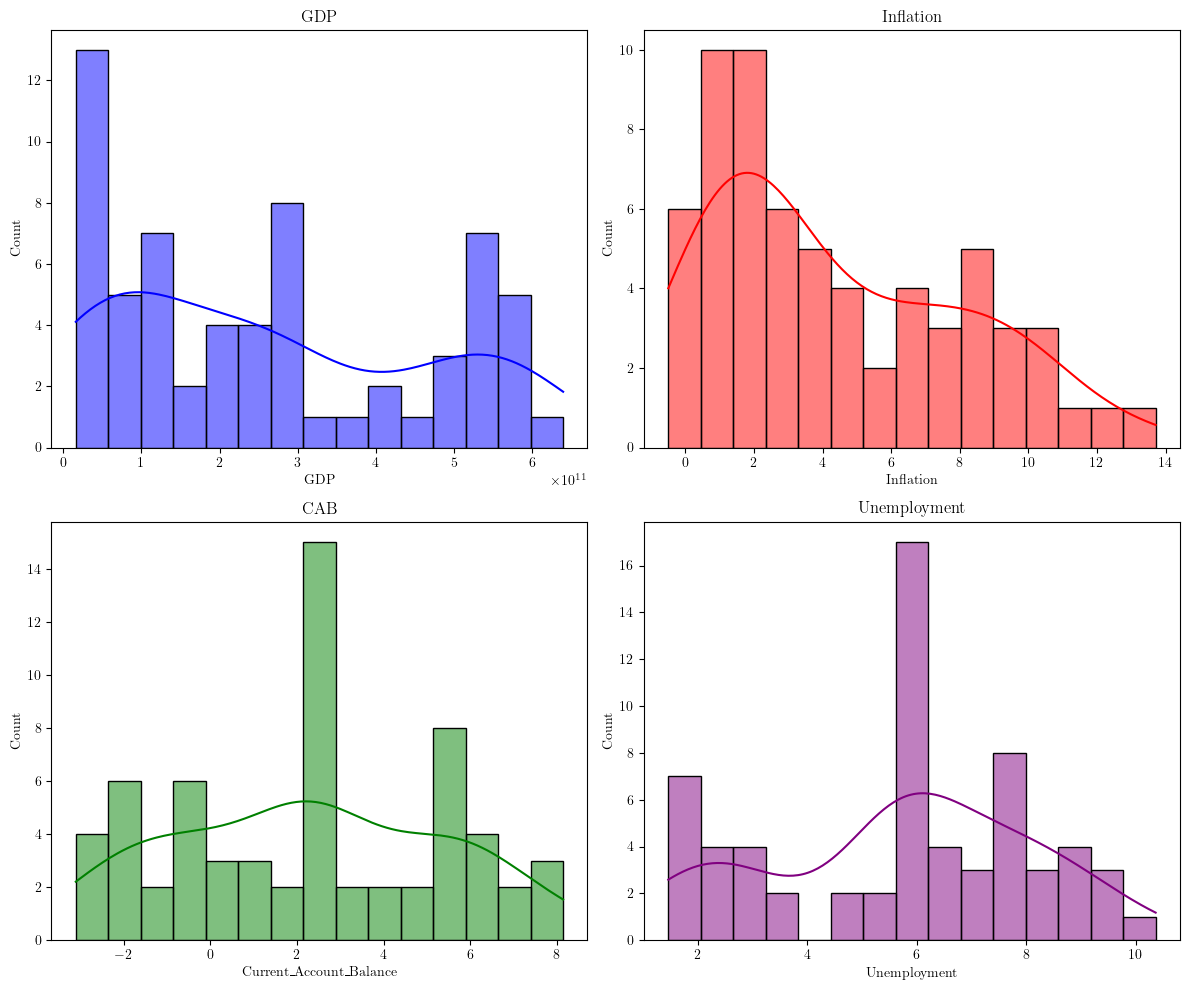

In [10]:
# 4. Distribution Analysis

# Creating histograms and KDE plots for each indicator
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram and KDE for GDP
sns.histplot(data['GDP'], kde=True, ax=axes[0, 0], color='blue', bins=15)
axes[0, 0].set_title('GDP')

# Histogram and KDE for Inflation
sns.histplot(data['Inflation'], kde=True, ax=axes[0, 1], color='red', bins=15)
axes[0, 1].set_title('Inflation')

# Histogram and KDE for Current Account Balance
sns.histplot(data['Current_Account_Balance'], kde=True, ax=axes[1, 0], color='green', bins=15)
axes[1, 0].set_title('CAB')

# Histogram and KDE for Unemployment
sns.histplot(data['Unemployment'], kde=True, ax=axes[1, 1], color='purple', bins=15)
axes[1, 1].set_title('Unemployment')

plt.tight_layout()
plt.savefig('histogram.pdf')
plt.show()


## Result:

The histograms and KDE plots reveal that GDP has a right-skewed distribution, with most values at lower levels and a long tail reflecting growth over time. Inflation is also slightly right-skewed, with spikes during periods of economic instability. The Current Account Balance is centered around zero, showing variability between surplus and deficit. Unemployment is relatively symmetric with a slight right skew, indicating mostly moderate levels but occasional periods of higher-than-average unemployment. Point to note, the central distribution of current account balance and Unemployment could be a manifestation of missing data points.

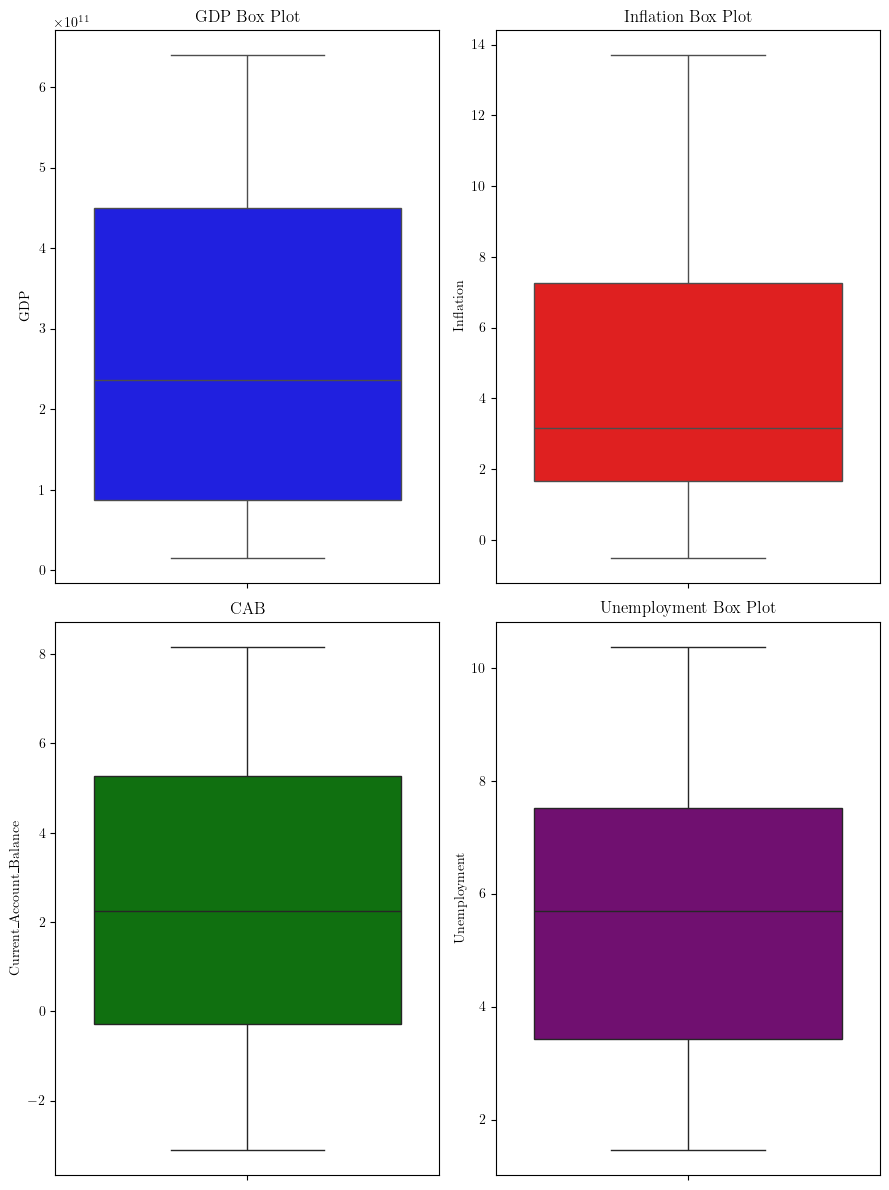

In [16]:
# Creating box plots to identify outliers and understand the distribution
fig, axes = plt.subplots(2, 2, figsize=(9, 12))

# Box plot for GDP
sns.boxplot(y=data['GDP'], ax=axes[0, 0], color='blue')
axes[0, 0].set_title('GDP Box Plot')

# Box plot for Inflation
sns.boxplot(y=data['Inflation'], ax=axes[0, 1], color='red')
axes[0, 1].set_title('Inflation Box Plot')

# Box plot for Current Account Balance
sns.boxplot(y=data['Current_Account_Balance'], ax=axes[1, 0], color='green')
axes[1, 0].set_title('CAB')

# Box plot for Unemployment
sns.boxplot(y=data['Unemployment'], ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Unemployment Box Plot')

plt.tight_layout()
plt.savefig('boxplots.pdf')
plt.show()

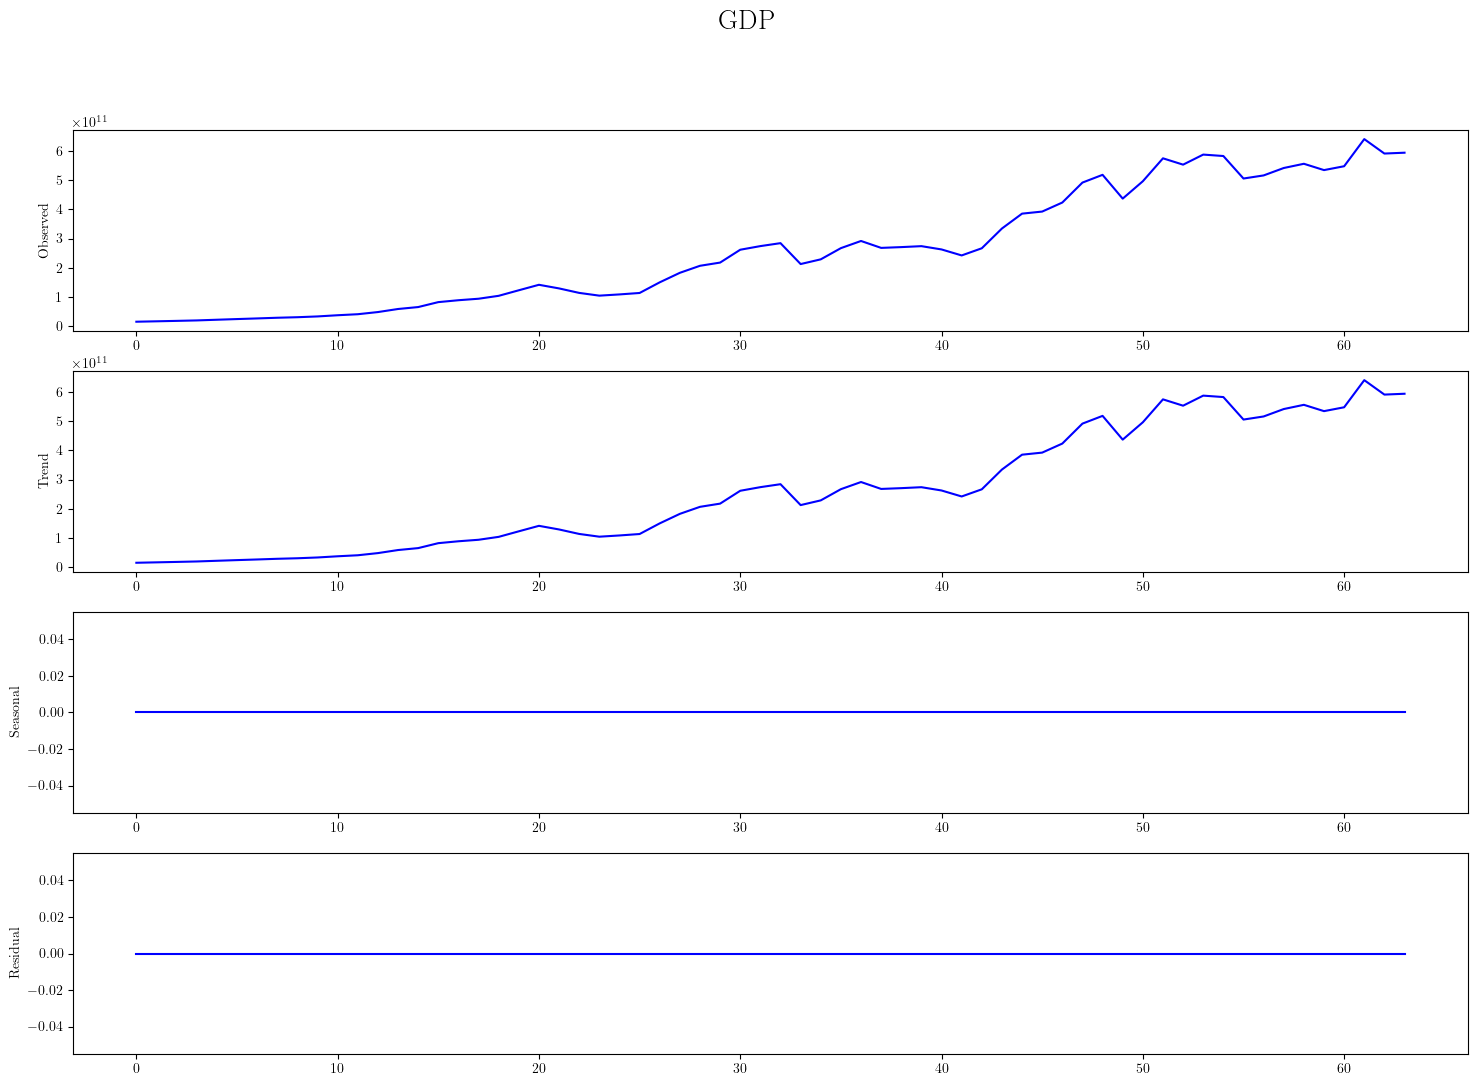

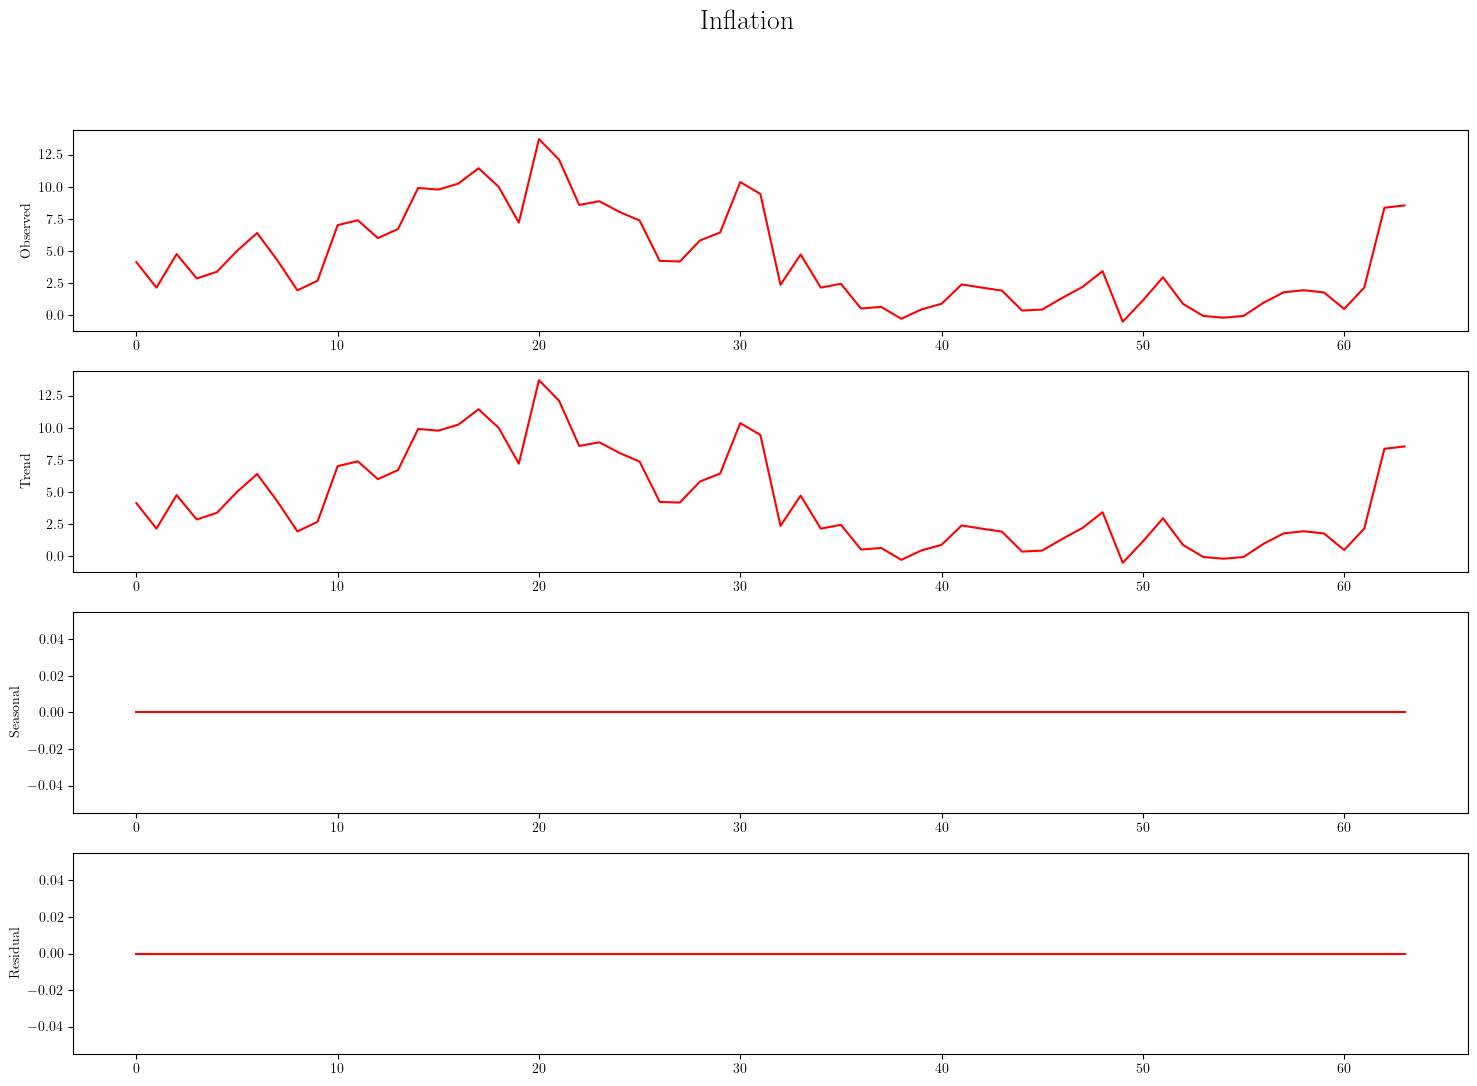

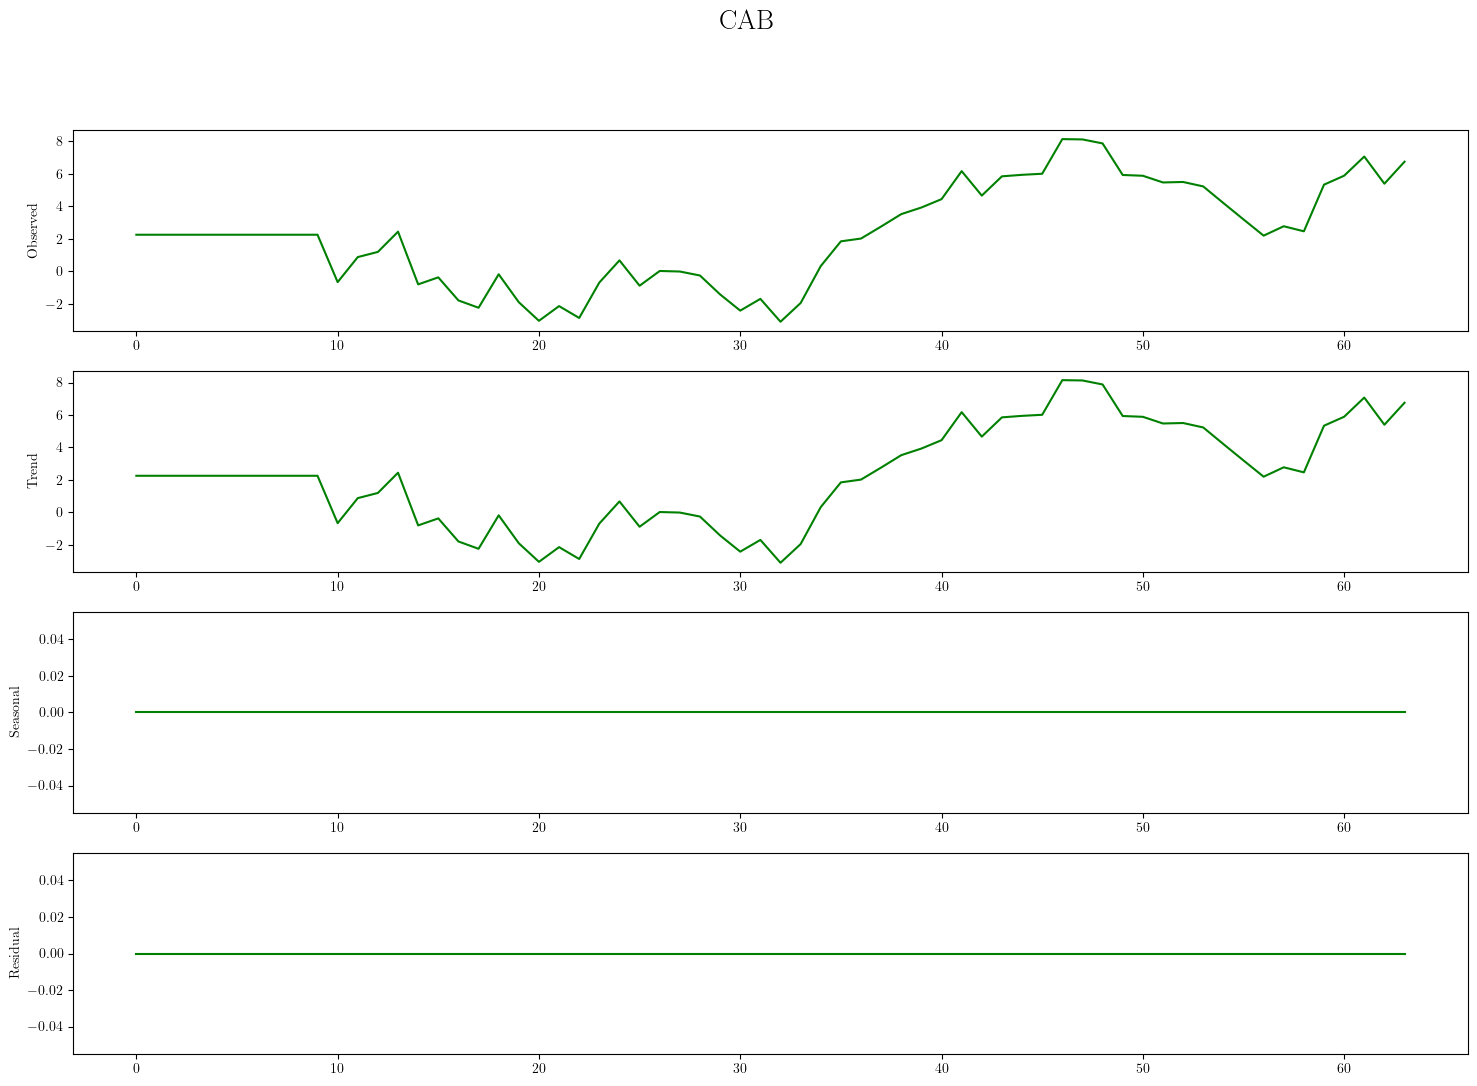

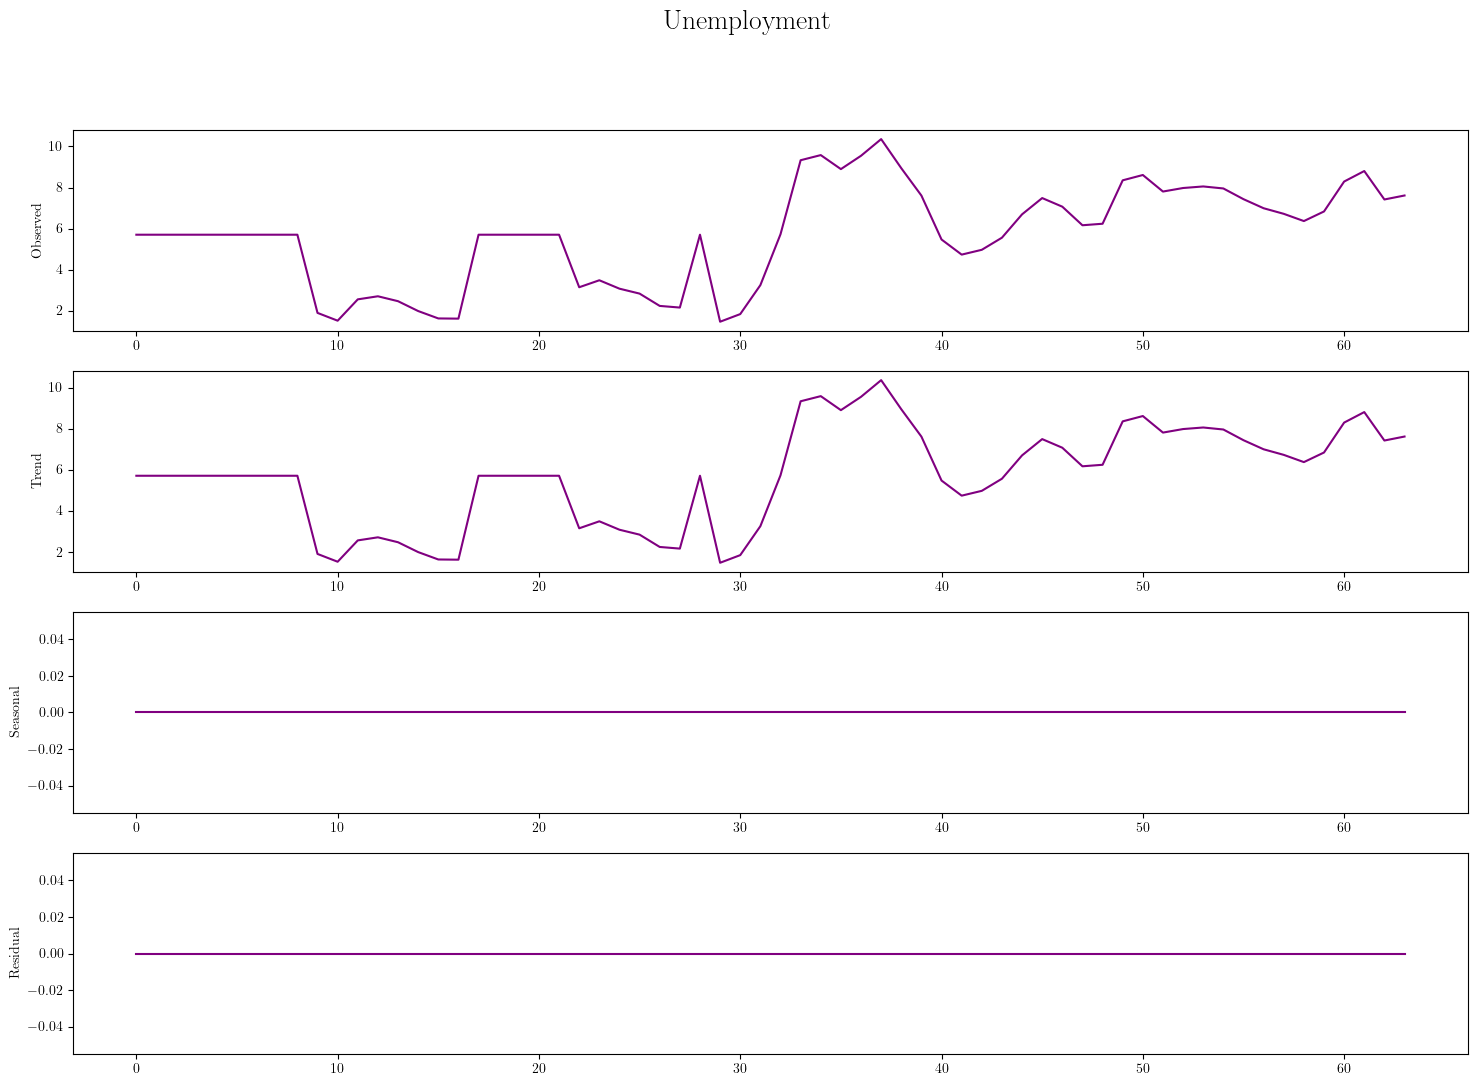

In [22]:
def plot_seasonal_decompose(result, title, colors):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(18, 12))
    
    # Observed
    result.observed.plot(ax=ax1, color=colors)
    ax1.set_ylabel('Observed')
    # Trend
    result.trend.plot(ax=ax2, color=colors)
    ax2.set_ylabel('Trend')
    # Seasonal
    result.seasonal.plot(ax=ax3, color=colors)
    ax3.set_ylabel('Seasonal')
    # Residual
    result.resid.plot(ax=ax4, color=colors)
    ax4.set_ylabel('Residual')
    plt.suptitle(title, fontsize=20)
    plt.show()

plot_seasonal_decompose(seasonal_decompose(data['GDP'], model='additive', period=1), 'GDP', colors='blue')
plot_seasonal_decompose(seasonal_decompose(data['Inflation'], model='additive', period=1), 'Inflation', colors='red')
plot_seasonal_decompose(seasonal_decompose(data['Current_Account_Balance'], model='additive', period=1), 'CAB', colors='green')
plot_seasonal_decompose(seasonal_decompose(data['Unemployment'], model='additive', period=1), 'Unemployment', colors='purple')

In [31]:
import ipywidgets as widgets
from IPython.display import display

indicator_dropdown = widgets.Dropdown(
    options=['GDP', 'Inflation', 'Current_Account_Balance', 'Unemployment'],
    value='GDP',
    description='Indicator:',
)

def update_plot(indicator):
    fig = px.line(data, x='Year', y=indicator, title=f'{indicator} Over Time')
    fig.show()

# Display the dropdown and plot
widgets.interact(update_plot, indicator=indicator_dropdown)

interactive(children=(Dropdown(description='Indicator:', options=('GDP', 'Inflation', 'Current_Account_Balance…

<function __main__.update_plot(indicator)>